In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# Feature Engineering

#### ვნახოთ როგორია ცვეტების და სტრიქონების რაოდენობა, სვეტების ტიპები, გამოტოვებული მონაცემები, ცვლადების განაწილებები და ა.შ.

In [4]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Id ეგრევე ამოვაგდოთ, რადგან არ გვჭირდება ტრენინგისთვის.

In [5]:
df_train = df_train.drop('Id', axis=1)
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_train.shape

(1460, 80)

#### ვნახოთ სვეტების შესახებ ინფორმაცია, რა ტიპის ცვლადებია, არის თუ არა გამოტოვებული მონაცემები და ა.შ.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

#### როგორც ვხედავთ, გვაქვს როგორც categorical, ისე numerical ცვლადები.

#### ვნახოთ target სვეტის ანუ "SalePrice"-ის აღწერითი სტატისტიკა და განაწილება.

In [8]:
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

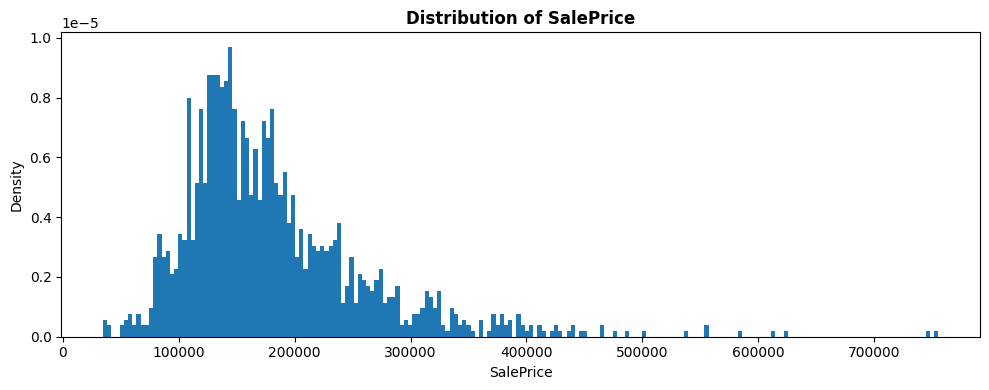

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(df_train["SalePrice"], bins=200, density=True, histtype='bar')
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title(f"Distribution of SalePrice", fontweight='bold')
plt.tight_layout()
plt.savefig("Distribution_of_SalePrice_in_train_set.png")
plt.show()

#### ამოვიღოთ categorical და numerical სვეტები, ვნახოთ მათი განაწილებები.

In [10]:
cat_cols = [col for col in df_train.columns if df_train[col].dtype == "object"]
num_cols = [col for col in df_train.columns if df_train[col].dtype != "object"]

In [11]:
df_cat = df_train[cat_cols]
df_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [12]:
df_num = df_train[num_cols]
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


#### Categorical Columns Distribution

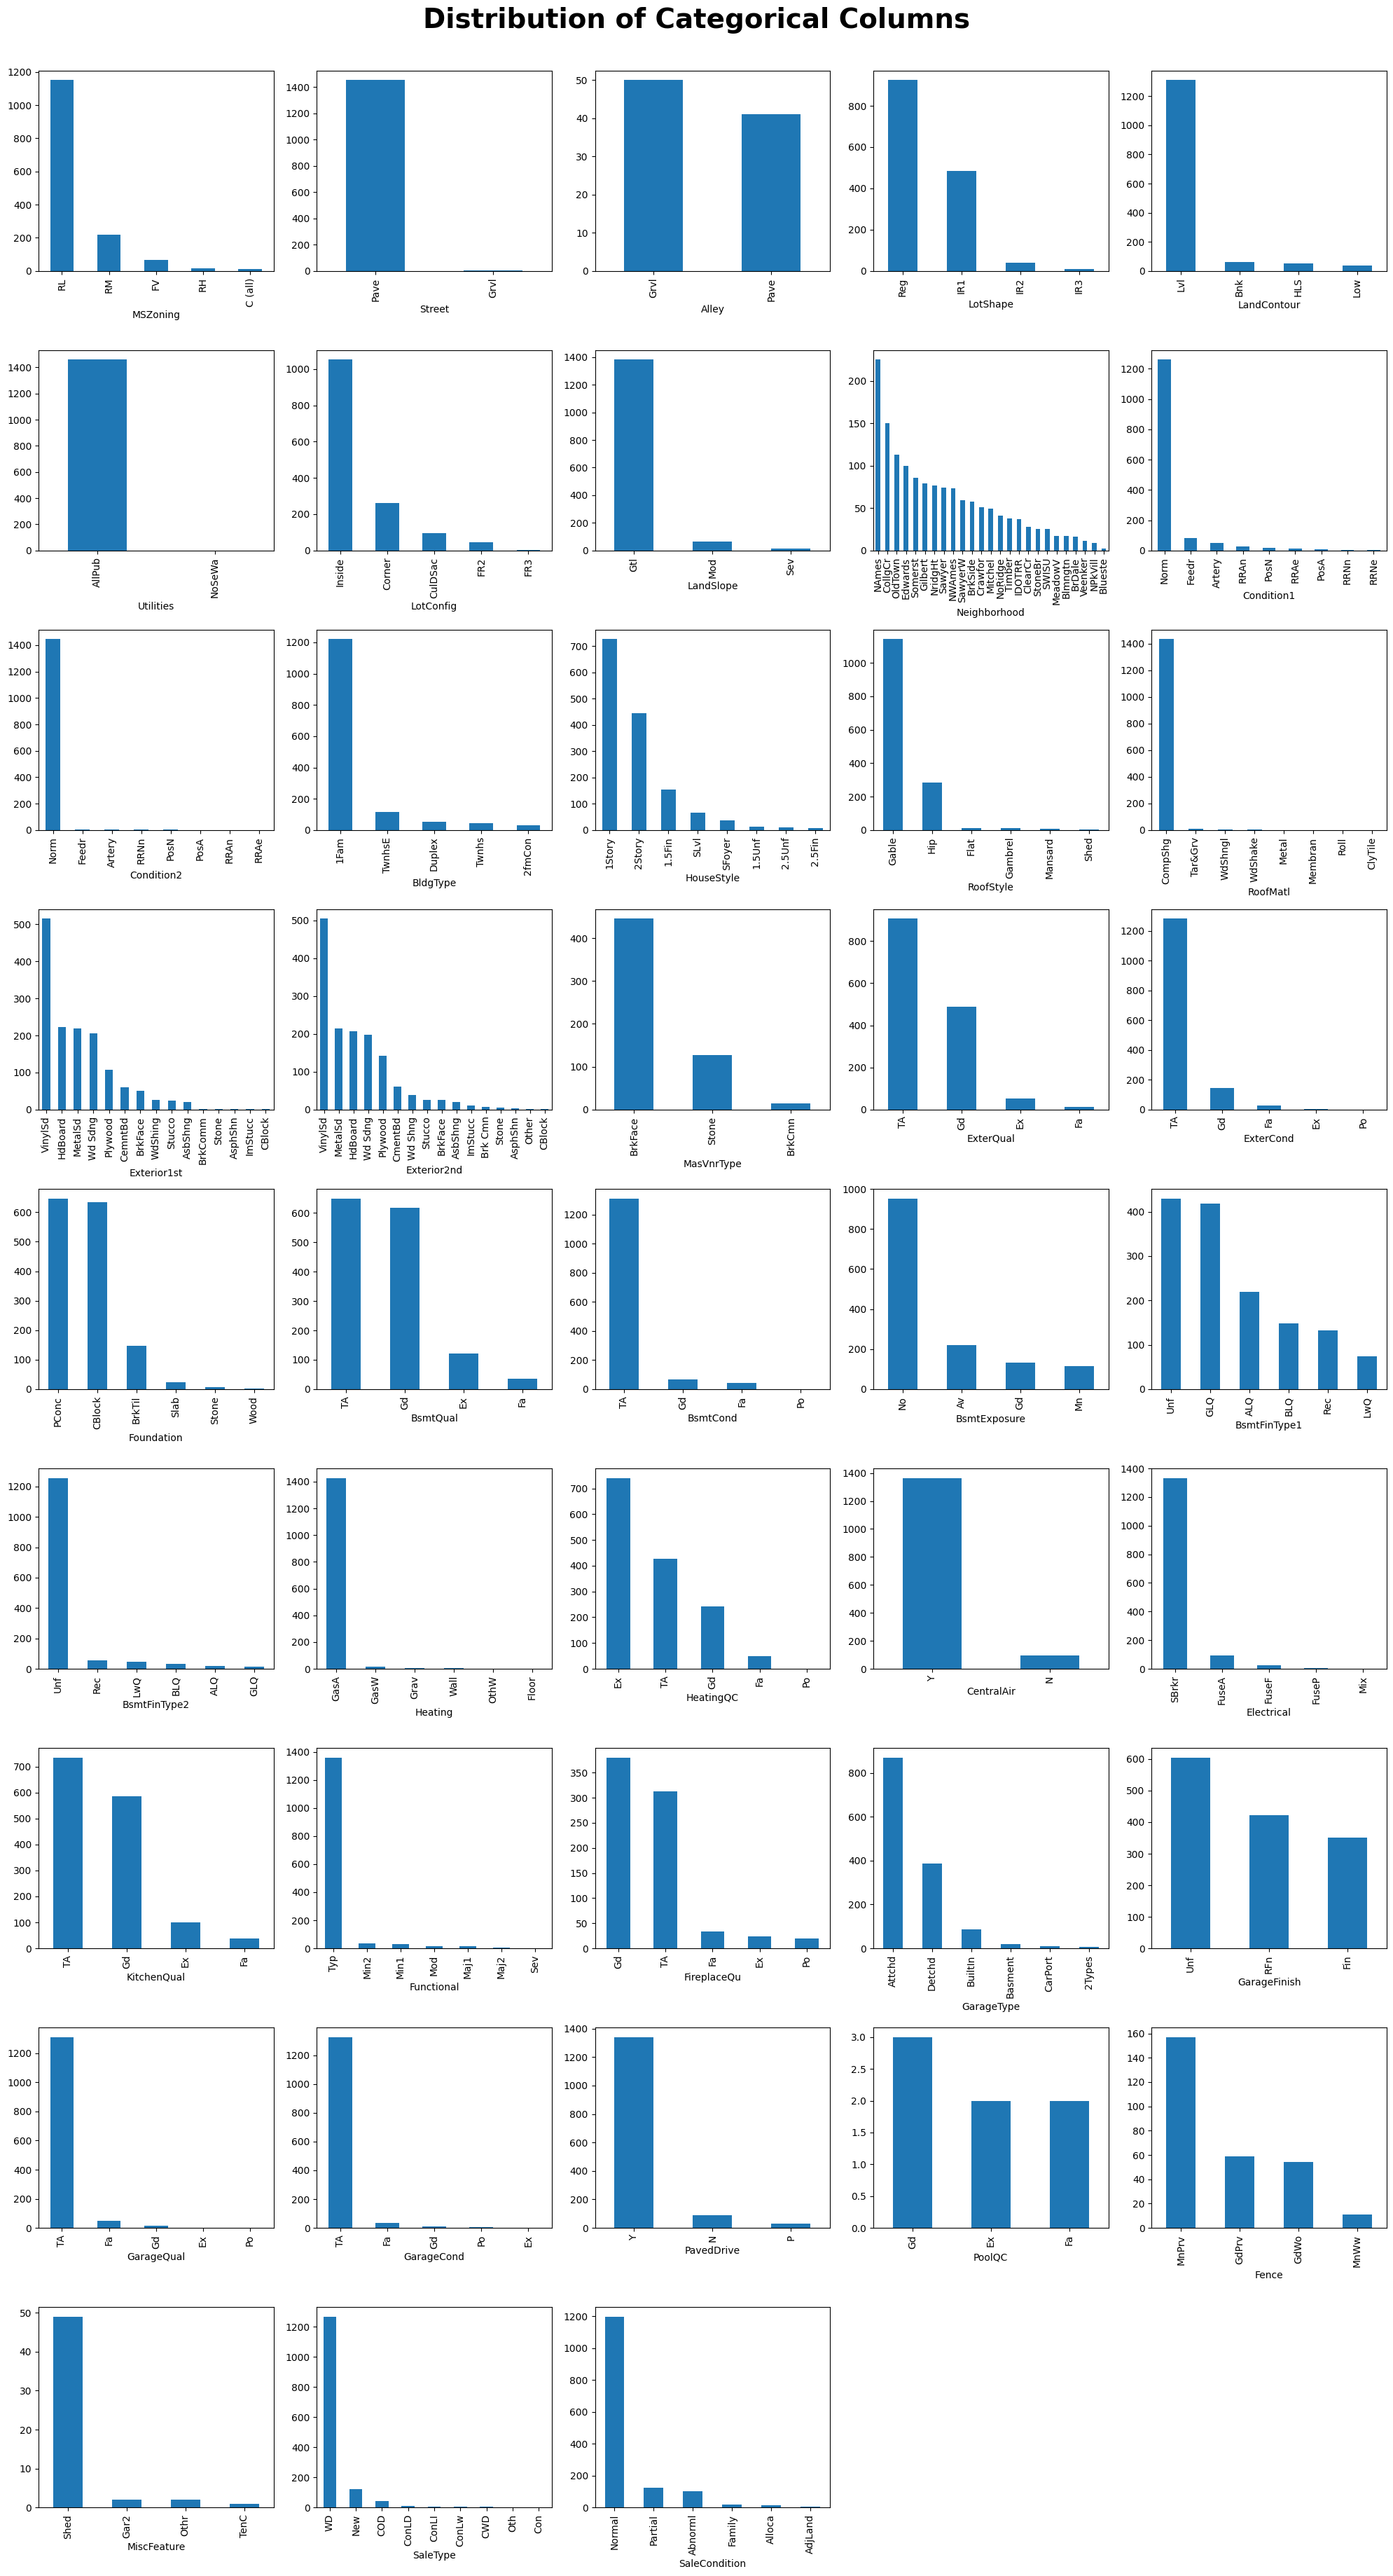

In [13]:
fig, axes = plt.subplots(9, 5, figsize=(20, 36))
axes = axes.flatten()

for i, col in enumerate(cat_cols):  
    df_cat[col].value_counts().plot(kind='bar', ax=axes[i])

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
fig.suptitle("Distribution of Categorical Columns", fontsize=28, fontweight='bold', y=1.02)
plt.savefig("Distribution_of_cat_cols_in_train_set.png")
plt.show()

#### Numerical Columns Distribution

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


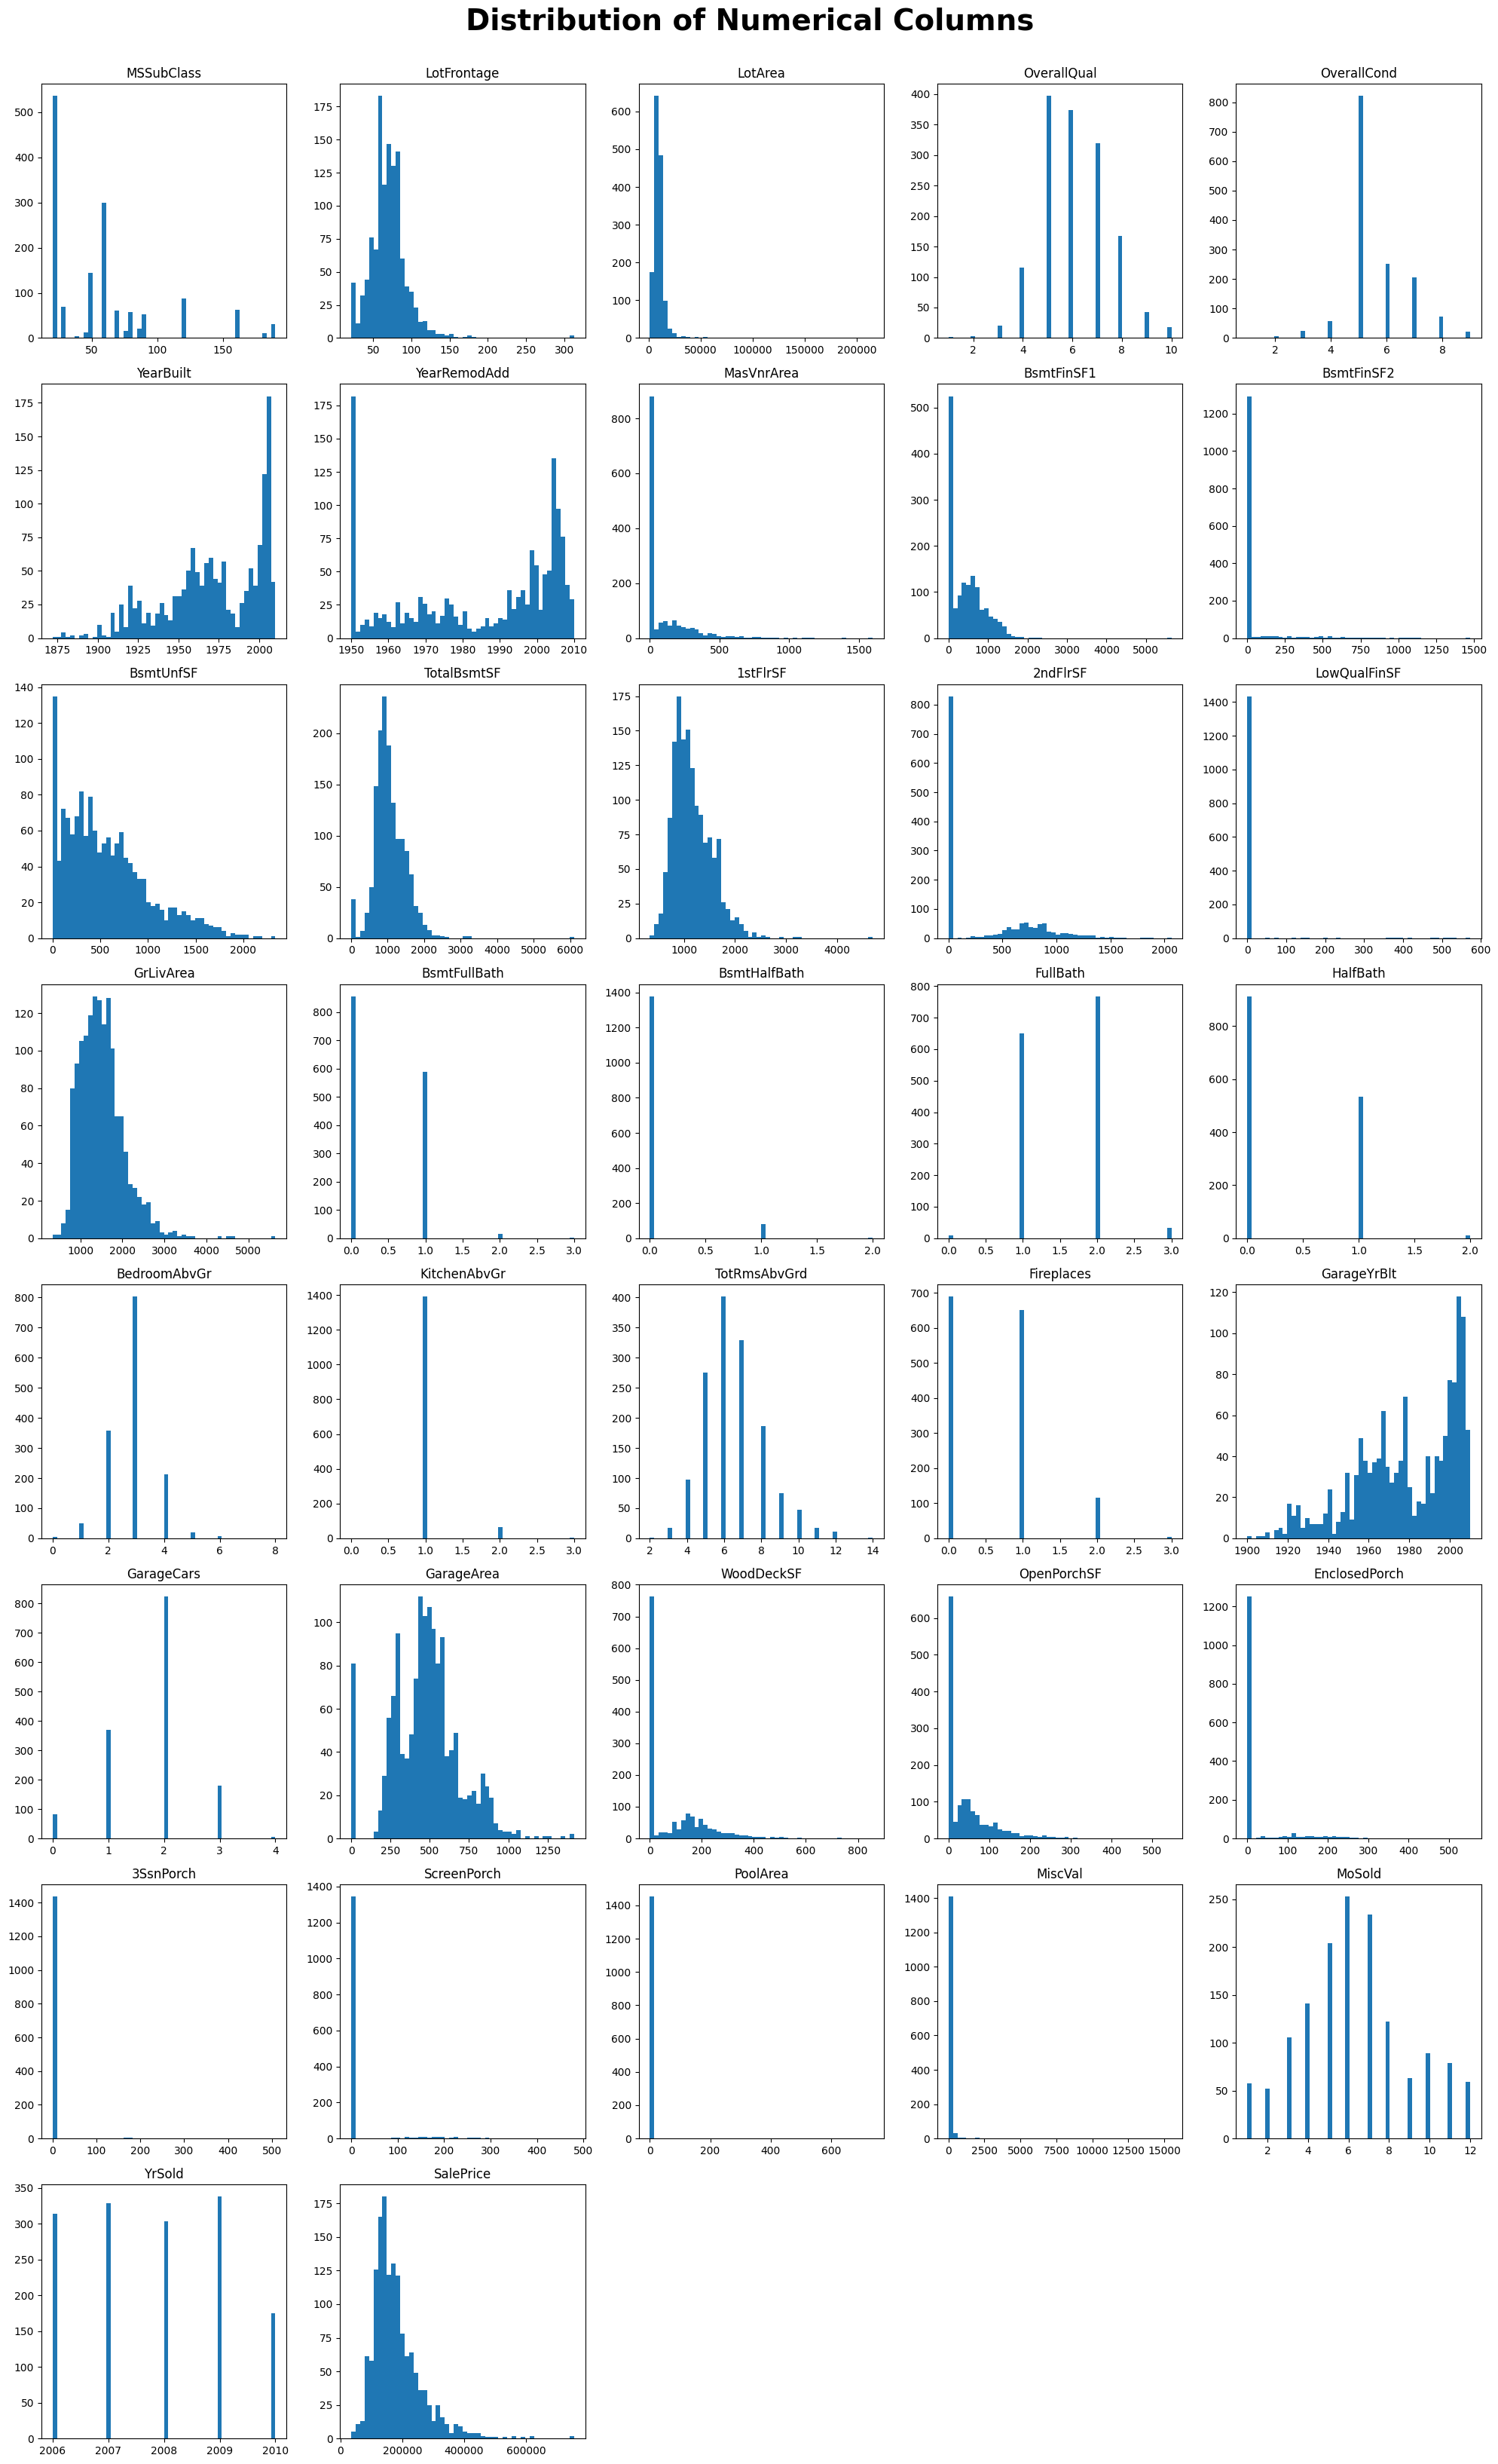

In [14]:
#df_num.hist(figsize=(25, 25), bins=50);

fig, axes = plt.subplots(8, 5, figsize=(20, 32))  
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df_num[col], bins=50)
    axes[i].set_title(col, fontsize=12)


fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.delaxes(axes[-3])
plt.tight_layout()
fig.suptitle("Distribution of Numerical Columns", fontsize=28, fontweight='bold', y=1.02)
plt.savefig("Distribution_of_num_cols_in_train_set.png")
plt.show()

#### ვნახოთ გამოტოვებული მონაცემების (Null value) რაოდენობა და პროცენტულობა როგორც categorical, ისე numerical სვეტებში.

In [15]:
# Null value count in categorical columns
cols_with_nulls = df_cat.columns[df_cat.isna().sum() > 0]

cat_cols_null_values = pd.DataFrame(
    {
        "Categorical Column" : cols_with_nulls,
        "Count": df_cat[cols_with_nulls].isna().sum(),
        "%": (df_cat[cols_with_nulls].isna().sum() / len(df_cat) * 100).round(2).astype(str) + " %",
    }
).sort_values(by="Count", ascending=False)


cat_cols_null_values.to_csv("null_values_cat_cols.csv", index=True, header=True)

cat_cols_null_values

,Categorical Column,Count,%
PoolQC,PoolQC,1453,99.52 %
MiscFeature,MiscFeature,1406,96.3 %
Alley,Alley,1369,93.77 %
Fence,Fence,1179,80.75 %
MasVnrType,MasVnrType,872,59.73 %
FireplaceQu,FireplaceQu,690,47.26 %
GarageType,GarageType,81,5.55 %
GarageFinish,GarageFinish,81,5.55 %
GarageQual,GarageQual,81,5.55 %
GarageCond,GarageCond,81,5.55 %


In [16]:
# Null value count in numerical columns
num_cols_with_nulls = df_num.columns[df_num.isna().sum() > 0]

num_cols_null_values = pd.DataFrame(
    {
        "Numerical Column": num_cols_with_nulls,
        "Count": df_num[num_cols_with_nulls].isna().sum(),
        "%": (df_num[num_cols_with_nulls].isna().sum() / len(df_num) * 100).round(2).astype(str) + " %",
    }
).sort_values(by="Count", ascending=False)

num_cols_null_values.to_csv("null_values_num_cols.csv", index=True, header=True)

num_cols_null_values

,Numerical Column,Count,%
LotFrontage,LotFrontage,259,17.74 %
GarageYrBlt,GarageYrBlt,81,5.55 %
MasVnrArea,MasVnrArea,8,0.55 %


In [17]:
pd.DataFrame(
    {
        "PoolQC- NA count" : [df_cat["PoolQC"].isna().sum()],
        "PoolArea- 0 count" : [df_num["PoolArea"][df_num["PoolArea"] == 0].count()]
    }, 
    index=[""]
)

,PoolQC- NA count,PoolArea- 0 count
,1453,1453


In [18]:
pd.DataFrame(
    {
        "MiscFeature- NA count" : [df_cat["MiscFeature"].isna().sum()],
        "MiscVal- 0 count" : [df_num["MiscVal"][df_num["MiscVal"] == 0].count()]
    }, 
    index=[""]
)

,MiscFeature- NA count,MiscVal- 0 count
,1406,1408


In [19]:
df_train[df_train["MiscVal"] == 0]["MiscFeature"].value_counts()

MiscFeature
Othr    1
Shed    1
Name: count, dtype: int64

In [20]:
pd.DataFrame(
    {
        "MasVnrType- NA count" : [df_cat["MasVnrType"].isna().sum()],
        "MasVnrArea- 0 count" : [df_num["MasVnrArea"][df_num["MasVnrArea"] == 0].count()]
    }, 
    index=[""]
)

,MasVnrType- NA count,MasVnrArea- 0 count
,872,861


In [21]:
pd.DataFrame(
    {
        "FireplaceQu- NA count" : [df_cat["FireplaceQu"].isna().sum()],
        "Fireplaces- 0 count" : [df_num["Fireplaces"][df_num["Fireplaces"] == 0].count()]
    }, 
    index=[""]
)

,FireplaceQu- NA count,Fireplaces- 0 count
,690,690


In [22]:
pd.DataFrame(
    {
        "GarageType- NA count" : [df_cat["GarageType"].isna().sum()],
        "GarageFinish- NA count" : [df_cat["GarageFinish"].isna().sum()],
        "GarageQual- NA count" : [df_cat["GarageQual"].isna().sum()],
        "GarageCond- NA count" : [df_cat["GarageCond"].isna().sum()],
        "GarageYrBlt- NA count" : [df_num["GarageYrBlt"].isna().sum()],
        "GarageArea- 0 count" : [df_num["GarageArea"][df_num["GarageArea"] == 0].count()],
        "GarageCars- 0 count" : [df_num["GarageCars"][df_num["GarageCars"] == 0].count()]
    }, 
    index=[""]
)

,GarageType- NA count,GarageFinish- NA count,GarageQual- NA count,GarageCond- NA count,GarageYrBlt- NA count,GarageArea- 0 count,GarageCars- 0 count
,81,81,81,81,81,81,81


In [23]:
pd.DataFrame(
    {
        "BsmtQual- NA count" : [df_cat["BsmtQual"].isna().sum()],
        "BsmtCond- NA count" : [df_cat["BsmtCond"].isna().sum()],
        "BsmtFinType1- NA count" : [df_cat["BsmtFinType1"].isna().sum()],
        "BsmtExposure- NA count" : [df_cat["BsmtExposure"].isna().sum()],
        "BsmtFinType2- NA count" : [df_cat["BsmtFinType2"].isna().sum()],
        "TotalBsmtSF- 0 count" : [df_num["TotalBsmtSF"][df_num["TotalBsmtSF"] == 0].count()]
    }, 
    index=[""]
)

,BsmtQual- NA count,BsmtCond- NA count,BsmtFinType1- NA count,BsmtExposure- NA count,BsmtFinType2- NA count,TotalBsmtSF- 0 count
,37,37,37,38,38,37


* 1453 (99.52%) null value გვაქვს კატეგორიულ სვეტში "PoolQC", რაც არის აუზის ხარისხი. თუ დავაკვირდებით მის შესაბამის numerical სვეტს, "PoolArea", რომელიც არის აუზის ფართობი, მისი 1453 მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ სახლების უმეტესობას აუზი არ აქვს, შესაბამისად "PoolQC" ანუ აუზის ხარისხის კატეგორიული მნიშვნელობები გამოტოვებულია.
* 1406 (96.3%) null value გვაქვს კატეგორიულ სვეტში "MiscFeature" რომელიც არის Miscellaneous feature not covered in other categories, რომლის შესაბამისი numerical ცვლადის "MiscVal"-ის ანუ $Value of miscellaneous feature-ის 1400-ზე მეტი მნიშვნელობა ასევე არის 0, რაც იმას ნიშნავს, რომ ეს მახასიათებელი სახლების უმეტესობას არ გააჩნია.
* 1369 (93.77%) null value გვაქვს კატეგორიულ სვეტში "Alley", რაც არის Type of alley access, რაც სავარაუდოდ სახლების უმეტესობას არ აქვს.
* 1179 (80.75%) null value გვაქვს კატეგორიულ სვეტში "Fence", რომელიც არის ღობის ხარისხი, ამიტომ ამდენი გამოტოვებული მონაცემის არსებობა სავარაუდოდ ნიშნავს, რომ სახლების უმეტესობას ღობე საერთოდ არ აქვს.
* 872 (59.73%) null value გვაქვს კატეგორიულ სვეტში "MasVnrType", რომელიც არის Masonry veneer type, რომლის შესაბამისი numerical სვეტია "MasVnrArea", რომლის 800-ზე მეტი მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ სახლების ნახევარზე მეტს Masonry veneer საერთოდ არ გააჩნია, შესაბამისად მისი ტიპის აღმნიშვნელი კატეგორიული ცვლადის მნიშვნელობები გამოტოვებულია.
* 690 (47.26%) null value გვაქვს კატეგორიულ სვეტში "FireplaceQu", რომელიც არის Fireplace quality. მისი შესაბამისი numerical ცვლადის "Fireplaces" ანუ Number of fireplaces, რომლის 690 მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ სახლების ამ რაოდენობას არ გააჩნია ბუხრები, შესაბამისად მისი ხარისხის აღმნიშვნელი კატეგორიული ცვლადის მნიშვნელობები ასეთი სახლებისთვის გამოტოვებულია.
* 81 (5.55%) null value გვაქვს კატეგორიულ სვეტებში "GarageType", "GarageFinish", "GarageQual", "GarageCond". მათი შესაბამისი numerical სვეტებია "GarageYrBlt"(რომელშიც ასევე 81 (5.55%) null value გვაქვს) და კიდევ "GarageCars" (Size of garage in car capacity) და "GarageArea" (Size of garage in square feet), რომლებშიც 81 მნიშვნელობა არის 0-ის ტოლი. სავარაუდოდ ჩვენი მონაცემებიდან 81 სახლს არ აქვს საერთოდ ავტოფარეხი და სწორედ ამიტომაა მათი შესაბამისი სვეტების მნიშვნელობები გამოტოვებული.
* 38 (2.6%) null value გვაქვს კატეგორიულ სვეტებში "BsmtExposure" და "BsmtFinType2", ხოლო 37 (2.53%) null value გვაქვს კატეგორიულ სვეტებში "BsmtQual", "BsmtCond" და "BsmtFinType1". ეს სვეტები არის basement-ის შესაბამისი კატეგორიული ცვლადები- მისი ხარისხი, მდგომარეობა და ტიპი. მისი შესაბამისი numerical ცვლადია "TotalBsmtSF"- Total square feet of basement area, რომლის 37 მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ მის შესაბამის კატეგორიულ სვეტებში გამოტოვებული მონაცემების არსებობა სავარაუდოდ აიხსნება იმით, რომ ამ სახლებს საერთოდ არ აქვთ basement.
* 1 (0.07%) null value გვაქვს კატეგორიულ სვეტში "Electrical", რომელიც არის Electrical system.

* 259 (17.74%) null value გვაქვს numerical სვეტში "LotFrontage" (Linear feet of street connected to property).
* 81 (5.55%) null value გვაქვს numerical სვეტში "GarageYrBlt", რაც უკვე აღვნიშნეთ ზემოთ.
* 8 (0.55%) null value გვაქვს numerical სვეტში "MasVnrArea" (Masonry veneer area in square feet).

# Cleaning

ამოვაგდოთ ისეთი სვეტები, სადაც გამოტოვებული მნიშვნელობები არის 80%-ზე მეტი. ასეთი კატეგორიული სვეტებია "Alley", "PoolQC", "Fence", "MiscFeature". 

In [24]:
null_counts = df_train.isna().sum()
null_counts = null_counts[null_counts > 0]

df_train = df_train.drop(columns=null_counts[(null_counts / len(df_train)) * 100 > 80].index)

In [25]:
df_train.shape

(1460, 76)

"MasVnrType"-ში გამოტოვებული მონაცემები შევავსოთ "None"-ით, თუ მისი შესაბამისი "MasVnrArea" არის 0, სხვა შემთხვევაში შევავსოთ მოდით.

In [26]:
df_train.loc[df_train["MasVnrArea"] == 0, "MasVnrType"] = "None"
df_train["MasVnrType"] = df_train["MasVnrType"].fillna(df_train["MasVnrType"].mode()[0])

"FireplaceQu"-ში გამოტოვებული მონაცემები შევავსოთ "None"-ით.

In [27]:
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("None")

garage-თან და basement-თან დაკავშირებულ კატეგორიულ ცვლადებში ("GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtExposure", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1") გამოტოვებული მონაცემები შევავსოთ "None"-ით, რადგან ავტოფარეხი და სარდაფი საერთოდ არ აქვთ ასეთ სახლებს.


In [28]:
df_train["GarageType"] = df_train["GarageType"].fillna("None")
df_train["GarageFinish"] = df_train["GarageFinish"].fillna("None")
df_train["GarageQual"] = df_train["GarageQual"].fillna("None")
df_train["GarageCond"] = df_train["GarageCond"].fillna("None")

df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("None")
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("None")
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("None")
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("None")
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("None")

"Electrical"-ში გამოტოვებული 1 მნიშვნელობა შევავსოთ მოდით. 

In [29]:
df_train["Electrical"] = df_train["Electrical"].fillna(df_train["Electrical"].mode()[0])

numerical "LotFrontage"-ში გამოტოვებული მონაცემები შევავსოთ მედიანით.

In [30]:
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(df_train["LotFrontage"].median())

numerical "MasVnrArea"-ში გამოტოვებული მონაცემები შევავსოთ 0-ით, თუ მისი შესაბამისი "MasVnrType" არის "None", სხვა შემთხვევაში შევავსოთ მედიანით.

In [31]:
df_train.loc[df_train["MasVnrType"] == "None", "MasVnrArea"] = 0
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(df_train["MasVnrArea"].median())

numerical "GarageYrBlt"-ში გამოტოვებული მონაცემები შევავსოთ 0-ით, რადგან ასეთ სახლებს ავტოფარეხი არ აქვთ.

In [32]:
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(0)

გადავამოწმოთ რომ null-ები არ იყოს დარჩენილი სადმე...

In [33]:
df_train.isna().sum()[df_train.isna().sum() > 0]

Series([], dtype: int64)

#### ახლა გვინდა რომ კატეგორიული ცვლადები გადავაქციოთ რიცხვითად, ამიტომ გამოვიყენოთ One Hot Encoding.

რადგან ჩვენი target ცვლადი არ არის ბინარული და არის უწყვეტი (სახლის ფასი), ამიტომ WOE-ს გამოყენება არ იქნება კარგი, რადგან ბინარული კლასიფიკაციისას გამოიყენება, ორი კლასის განაწილებას უყურებს (0 და 1, Good და Bad და ა.შ), რაც ამ შემთხვევაში არ გვაქვს.

In [34]:
cat_cols = [col for col in df_train.columns if df_train[col].dtype == "object"]
num_cols = [col for col in df_train.columns if df_train[col].dtype != "object"]

In [35]:
len(cat_cols), len(num_cols)

(39, 37)

In [36]:
one_hot_cat_cols = cat_cols

In [37]:
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(df_train[cat_cols])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols))
df_encoded = pd.concat([df_train[num_cols], df_encoded], axis=1)
print(df_encoded.head())

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0          2003       196.0         706           0  ...             0.0   
1          1976         0.0         978           0  ...             0.0   
2          2002       162.0         486           0  ...             0.0   
3          1970         0.0         216           0  ...             0.0   
4          2000       350.0         655           0  ...             0.0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0.0       

In [38]:
len(df_encoded.columns)

247

In [39]:
num_all_cols_after_one_hot = len(df_encoded.columns)

# Feature Selection

მიღებული 247 ცვლადოსთვის (სვეტისთვის) დავითვალოთ კორელაციის მატრიცა.

In [40]:
corr_matrix = df_encoded.corr()

# too many features, hard to plot correlation matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Correlation Matrix")
# plt.show()

თავდაპირველად კორელაციის threshold ავიღოთ 0.5 და გავფილტროთ მიღებული 247 ცვლადი.

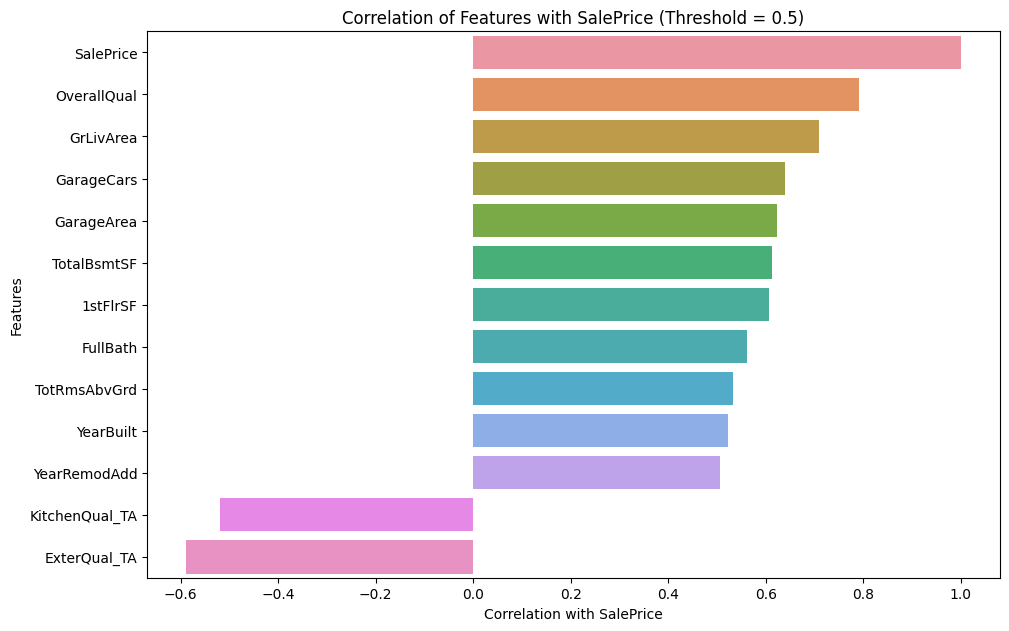

In [41]:
target_corr = corr_matrix["SalePrice"]
strong_corr_features = target_corr[(abs(target_corr) > 0.5)].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=strong_corr_features.values, y=strong_corr_features.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('Features')
plt.title('Correlation of Features with SalePrice (Threshold = 0.5)')
plt.savefig("corr_with_target_threshold_0.5.png")
plt.show()

In [42]:
strong_corr_features

SalePrice         1.000000
OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
KitchenQual_TA   -0.519298
ExterQual_TA     -0.589044
Name: SalePrice, dtype: float64

In [43]:
strongly_corr_cols = strong_corr_features.index
print(strongly_corr_cols)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'KitchenQual_TA', 'ExterQual_TA'],
      dtype='object')


target ცვლადის (SalePrice) ჩათვლით მივიღეთ 13 feature.

In [44]:
final_cols = strongly_corr_cols.tolist() 
print(final_cols)

['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'KitchenQual_TA', 'ExterQual_TA']


In [45]:
df_final = df_encoded[final_cols]

მიღებული 12 feature-ით (SalePrice-ის ჩაუთვლელად) KFold cross validation-ით და grid search-ით დავატრენინგოთ სხვადასხვა მოდელები (როგორც წრფივი, ისე ხეებზე დაფუძნებული მოდელები) სხვადასხვა ჰიპერპარამეტრებით, ამოვარჩიოთ თითოეული მოდელისთვის საუკეთესო ჰიპერპარამეტრები R2 score-ის მიხედვით (hyperparameter tuning) და ვნახოთ თითოეული მოდელის საბოლოო R2 score-ები.

In [46]:
X = df_final.drop(["SalePrice"], axis=1)
y = df_final["SalePrice"]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    None
]

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "scaler": scalers
        }  
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [10, 50, 100, 200, 300],
            "regressor__solver": ["auto", "svd", "cholesky", "lsqr"]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [10, 30, 50, 100, 150]
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [1, 5, 10],  
            "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "scaler": scalers, 
            "regressor__max_depth": [5, 10, 15, 20],
            "regressor__min_samples_split": [2, 5, 10, 15],
            "regressor__min_samples_leaf": [1, 2, 5, 10, 15],
            "regressor__max_features": ["sqrt", "log2", None]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__max_depth": [5, 10, 15, 20],
            "regressor__min_samples_split": [2, 3, 5, 7],
            "regressor__min_samples_leaf": [1, 2, 5, 7, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__learning_rate": [0.01, 0.05, 0.1],
            "regressor__max_depth": [3, 5, 7],
            "regressor__gamma": [0, 0.1, 0.5]
        }
    }
}

best_models = {}
best_scores = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", config["model"])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        cv=kfold,
        scoring='r2',
        return_train_score=True
    )

    grid_search.fit(X, y)
    best_models[name] = grid_search.best_params_
    best_scores[name] = grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")


for name, params in best_models.items():
    print(f"{name}: Best parameters = {params}")
    
for name, score in best_scores.items():
    print(f"{name}: Best R² = {score:.4f}")


Training Linear Regression...
Best parameters for Linear Regression: {'scaler': MinMaxScaler()}
Best cross-validation score: 0.7373

Training Ridge Regression...
Best parameters for Ridge Regression: {'regressor__alpha': 200, 'regressor__solver': 'lsqr', 'scaler': StandardScaler()}
Best cross-validation score: 0.7461

Training Lasso Regression...
Best parameters for Lasso Regression: {'regressor__alpha': 100, 'scaler': MinMaxScaler()}
Best cross-validation score: 0.7400

Training ElasticNet...
Best parameters for ElasticNet: {'regressor__alpha': 5, 'regressor__l1_ratio': 0.95, 'scaler': StandardScaler()}
Best cross-validation score: 0.7455

Training Decision Tree...
Best parameters for Decision Tree: {'regressor__max_depth': 10, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 5, 'scaler': None}
Best cross-validation score: 0.7832

Training Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': 15, 'regressor__mi

ახლა კორელაციის threshold ავიღოთ 0.6 და ვნახოთ ნაკლები feature-ით თუ გვექნება უკეთესი შედეგი თითოეული მოდელისთვის.

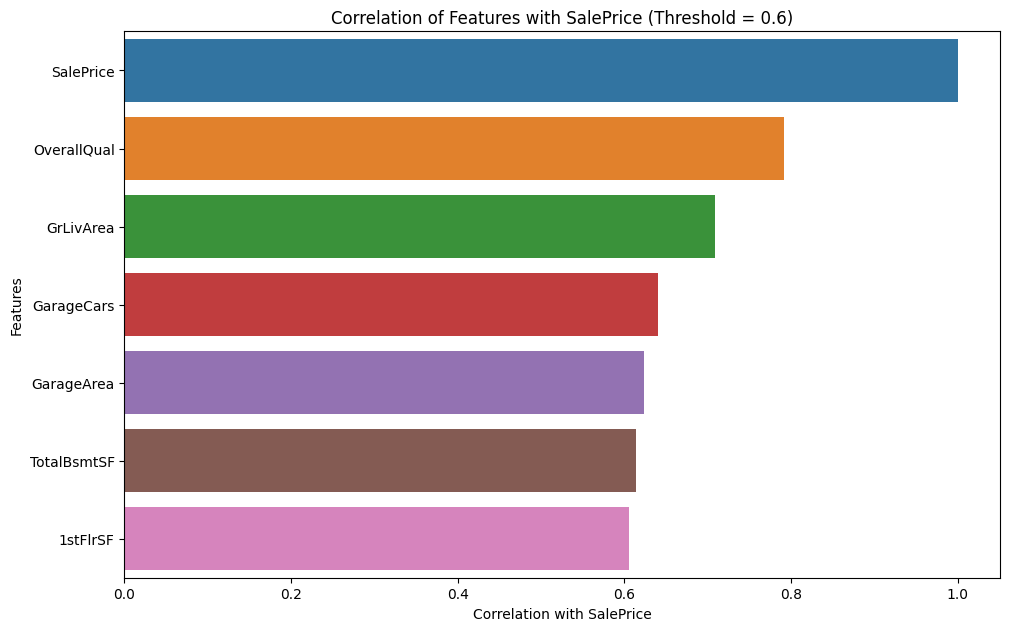

In [47]:
target_corr = corr_matrix["SalePrice"]
new_strong_corr_features = target_corr[(abs(target_corr) > 0.6)].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=new_strong_corr_features.values, y=new_strong_corr_features.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('Features')
plt.title('Correlation of Features with SalePrice (Threshold = 0.6)')
plt.savefig("corr_with_target_threshold_0.6.png")
plt.show()

In [48]:
new_features = new_strong_corr_features.index.tolist()
df_final_new = df_encoded[new_features]

In [49]:
X_ = df_final_new.drop(["SalePrice"], axis=1)
y_ = df_final_new["SalePrice"]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    None
]

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "scaler": scalers
        }  
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [10, 50, 100, 200, 300],
            "regressor__solver": ["auto", "svd", "cholesky", "lsqr"]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [10, 30, 50, 100, 150]
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [1, 5, 10],  
            "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "scaler": scalers, 
            "regressor__max_depth": [5, 10, 15, 20],
            "regressor__min_samples_split": [2, 5, 10, 15],
            "regressor__min_samples_leaf": [1, 2, 5, 10, 15],
            "regressor__max_features": ["sqrt", "log2", None]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__max_depth": [5, 10, 15, 20],
            "regressor__min_samples_split": [2, 3, 5, 7],
            "regressor__min_samples_leaf": [1, 2, 5, 7, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__learning_rate": [0.01, 0.05, 0.1],
            "regressor__max_depth": [3, 5, 7],
            "regressor__gamma": [0, 0.1, 0.5]
        }
    }
}


best_models_ = {}
best_scores_ = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", config["model"])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        cv=kfold,
        scoring='r2',
        return_train_score=True
    )

    grid_search.fit(X_, y_)
    best_models_[name] = grid_search.best_params_
    best_scores_[name] = grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")


for name, params in best_models_.items():
    print(f"{name}: Best parameters = {params}")

for name, score in best_scores_.items():
    print(f"{name}: Best R² = {score:.4f}")


Training Linear Regression...
Best parameters for Linear Regression: {'scaler': StandardScaler()}
Best cross-validation score: 0.7288

Training Ridge Regression...
Best parameters for Ridge Regression: {'regressor__alpha': 100, 'regressor__solver': 'lsqr', 'scaler': StandardScaler()}
Best cross-validation score: 0.7326

Training Lasso Regression...
Best parameters for Lasso Regression: {'regressor__alpha': 150, 'scaler': StandardScaler()}
Best cross-validation score: 0.7290

Training ElasticNet...
Best parameters for ElasticNet: {'regressor__alpha': 10, 'regressor__l1_ratio': 0.99, 'scaler': StandardScaler()}
Best cross-validation score: 0.7327

Training Decision Tree...
Best parameters for Decision Tree: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 10, 'regressor__min_samples_split': 10, 'scaler': None}
Best cross-validation score: 0.7682

Training Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': 10, 'regres

აშკარად ცოტა უარესი შედეგი აქვს ყველა მოდელზე (საუკეთესო მაინც Random Forest-ია, თუმცა უფრო ნაკლები R2 score-ით). ამიტომ ისევ წინა feature-ები ჯობია ჯერჯერობით და Random Forest, რომელსაც 0.82 ჰქონდა R2 score.

ვცადოთ RFE-იც feature-ების შერჩევისთვის. ჯერ კორელაციის ფილტრით გავფილტროთ, რადგან 247 ცვლადი გვაქვს და შემდეგ გამოვიყენოთ RFE.

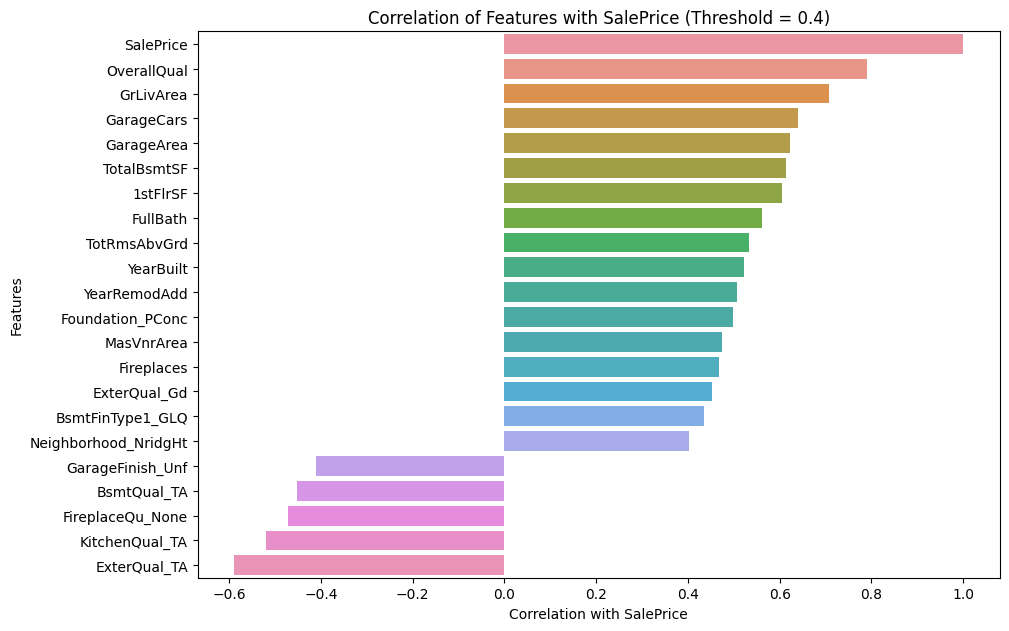

In [50]:
target_corr = corr_matrix["SalePrice"]
corr_features_rfe = target_corr[(abs(target_corr) > 0.4)].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_features_rfe.values, y=corr_features_rfe.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('Features')
plt.title('Correlation of Features with SalePrice (Threshold = 0.4)')
plt.savefig("corr_with_target_threshold_0.4_rfe.png")
plt.show()

In [51]:
len(corr_features_rfe)

22

247 ცვლადიდან კორელაციის ფილტრით დავტოვეთ 22 ცვლადი, ახლა კი RFE-ით შევარჩიოთ top 10.

In [52]:
rfe_features_corr = corr_features_rfe.index.tolist()
df_rfe = df_encoded[rfe_features_corr]

Features selected by RFE:
1. OverallQual
2. GrLivArea
3. GarageCars
4. GarageArea
5. TotalBsmtSF
6. 1stFlrSF
7. TotRmsAbvGrd
8. YearBuilt
9. YearRemodAdd
10. MasVnrArea


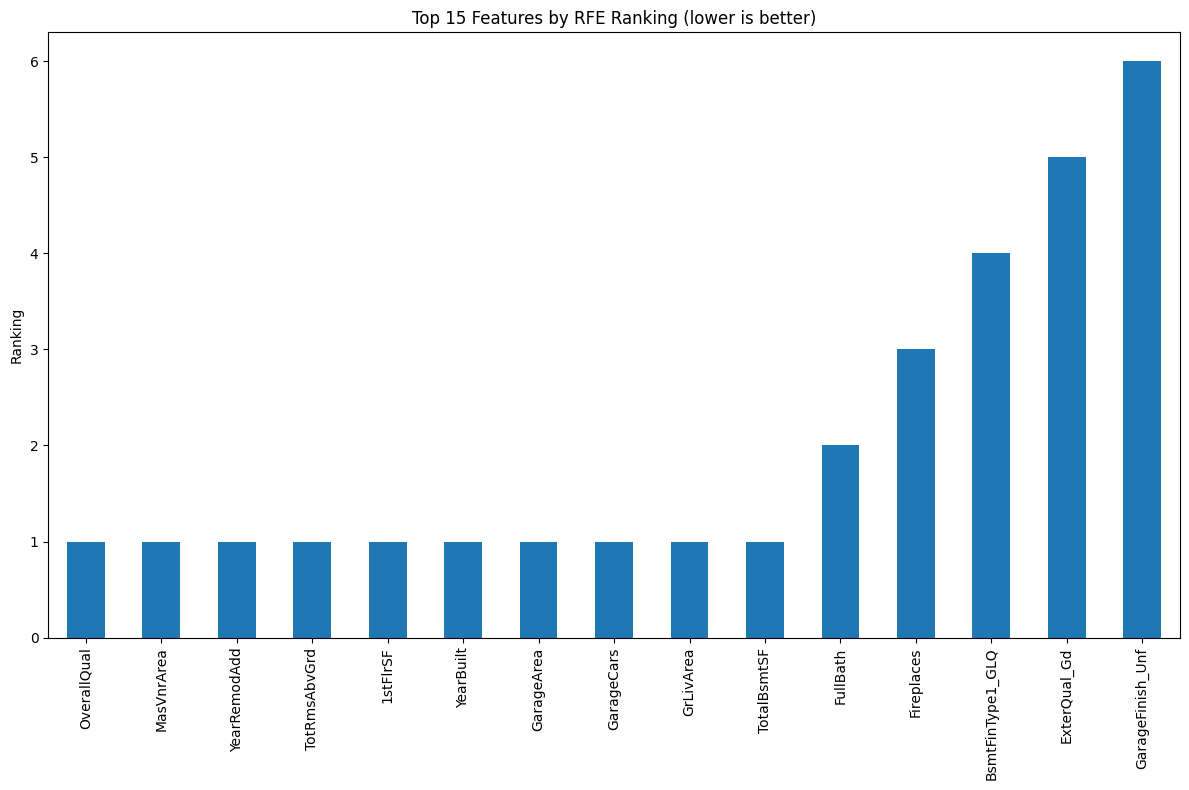

In [82]:
X_train_rfe = df_rfe.drop(["SalePrice"], axis=1)
y_train_rfe = df_rfe["SalePrice"]

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_rfe),
    columns=X_train_rfe.columns
)

model = RandomForestRegressor()

rfe = RFE(estimator=model, n_features_to_select=10, step=1)
rfe.fit(X_train_scaled, y_train_rfe)

rfe_selected_features = X_train_rfe.columns[rfe.support_].tolist()

print("Features selected by RFE:")
for i, feature in enumerate(rfe_selected_features, 1):
    print(f"{i}. {feature}")

plt.figure(figsize=(12, 8))
feature_ranking = pd.Series(rfe.ranking_, index=X_train_rfe.columns)
feature_ranking.sort_values().head(15).plot(kind='bar')
plt.title('Top 15 Features by RFE Ranking (lower is better)')
plt.ylabel('Ranking')
plt.tight_layout()
plt.savefig("rfe.png")
plt.show()

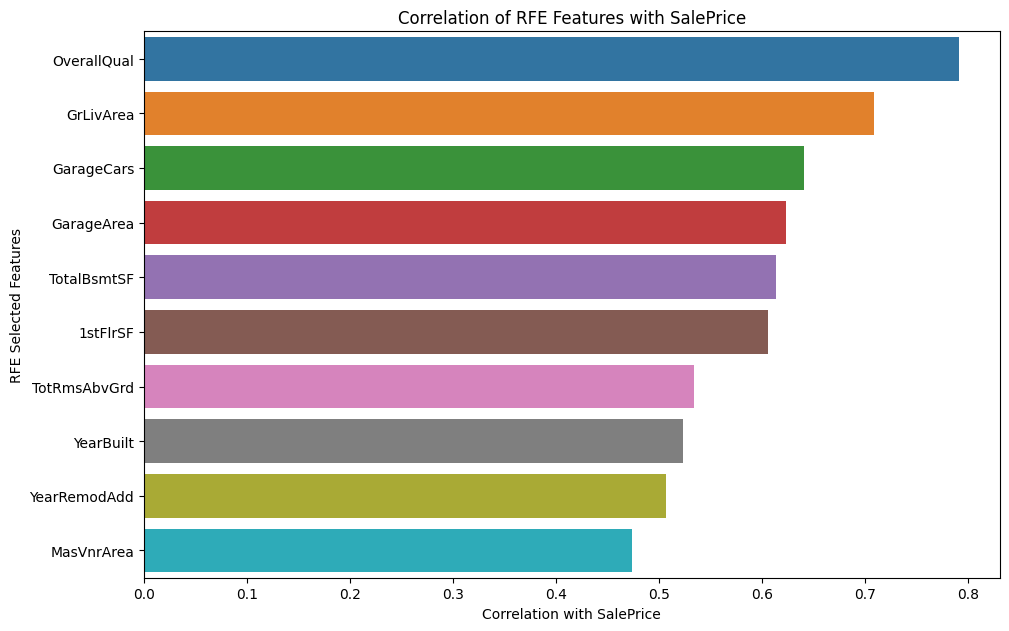

In [54]:
target_corr = corr_matrix["SalePrice"]
rfe_features_corr = target_corr[rfe_selected_features].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_features_corr.values, y=rfe_features_corr.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('RFE Selected Features')
plt.title('Correlation of RFE Features with SalePrice')
plt.savefig("corr_with_target_rfe.png")
plt.show()

ვნახოთ RFE-ით შერჩეული 10 feature რა შედეგებს მოგვცემს იგივე მოდელებისთვის.

In [55]:
X_rfe = X_train_rfe[rfe_selected_features]
y_rfe = y_train_rfe

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    None
]

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "scaler": scalers
        }  
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [10, 50, 100, 200, 300],
            "regressor__solver": ["auto", "svd", "cholesky", "lsqr"]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [10, 30, 50, 100, 150]
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [1, 5, 10],  
            "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "scaler": scalers, 
            "regressor__max_depth": [5, 10, 15, 20, 30],
            "regressor__min_samples_split": [2, 5, 10, 15],
            "regressor__min_samples_leaf": [1, 2, 5, 10, 15],
            "regressor__max_features": ["sqrt", "log2", None]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__max_depth": [5, 10, 15, 20],
            "regressor__min_samples_split": [2, 3, 5, 7],
            "regressor__min_samples_leaf": [1, 2, 5, 7, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "regressor__max_depth": [3, 5, 7],
            "regressor__gamma": [0, 0.1, 0.5]
        }
    }
}

best_models_rfe = {}
best_scores_rfe = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", config["model"])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        cv=kfold,
        scoring='r2',
        return_train_score=True
    )

    grid_search.fit(X_rfe, y_rfe)
    best_models_rfe[name] = grid_search.best_params_
    best_scores_rfe[name] = grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")


for name, params in best_models_rfe.items():
    print(f"{name}: Best parameters = {params}")
    
for name, score in best_scores_rfe.items():
    print(f"{name}: Best R² = {score:.4f}")


Training Linear Regression...
Best parameters for Linear Regression: {'scaler': StandardScaler()}
Best cross-validation score: 0.7381

Training Ridge Regression...
Best parameters for Ridge Regression: {'regressor__alpha': 200, 'regressor__solver': 'lsqr', 'scaler': StandardScaler()}
Best cross-validation score: 0.7469

Training Lasso Regression...
Best parameters for Lasso Regression: {'regressor__alpha': 100, 'scaler': MinMaxScaler()}
Best cross-validation score: 0.7413

Training ElasticNet...
Best parameters for ElasticNet: {'regressor__alpha': 5, 'regressor__l1_ratio': 0.95, 'scaler': StandardScaler()}
Best cross-validation score: 0.7466

Training Decision Tree...
Best parameters for Decision Tree: {'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 10, 'regressor__min_samples_split': 5, 'scaler': MinMaxScaler()}
Best cross-validation score: 0.7780

Training Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': 10, '

ისევ ცოტათი ნაკლები R2 score-ები მივიღეთ ხეებზე დაფუძნებულ მოდელებში, წრფივებში ცოტა უკეთესი, მაგრამ საუკეთესო მაინც Random Forest-ია ნაკლები score-ით, ამიტომ ისევ საწყისი 12 feature დავტოვოთ, რომელიც კორელაციის ფილტრით მივიღეთ 0.5 threshold-ით.

# Training

იმისთვის, რომ ისევ ხელით არ მოგვიწიოს სატრენინგო და სატესტო მონაცემების preprocessing-ი, შევქმნათ კლასი სადაც შემავალი მონაცემები preprocessing-ის ყველა იმ ნაბიჯს გაივლის, რაც თავდაპირველად სატრენინგო მონაცემებზე გავაკეთეთ, ვიდრე საუკეთესო მოდელს ავარჩევდით.

In [5]:
# 12 features selected with correlation filter (threshold=0.5)
final_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
              '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 
              'YearRemodAdd', 'KitchenQual_TA', 'ExterQual_TA']

In [6]:
class HousePricePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.encoder = None
        self.mas_vnr_type_mode = None
        self.electrical_mode = None
        self.lot_frontage_median = None
        self.mas_vnr_area_median = None
        self.selected_features = selected_features
    
    def fit(self, X, y=None):
        """Learn necessary statistics from training data."""
        df = X.copy()
        
        # Store modes and medians
        self.mas_vnr_type_mode = df["MasVnrType"].mode()[0]
        self.electrical_mode = df["Electrical"].mode()[0]
        self.lot_frontage_median = df["LotFrontage"].median()
        self.mas_vnr_area_median = df["MasVnrArea"].median()
    

        # Fit OneHotEncoder on categorical features
        exclude_cols = ["Id", "Alley", "PoolQC", "Fence", "MiscFeature"]
        cat_cols = [col for col in df.columns if df[col].dtype == "object" and col not in exclude_cols]
        
        self.encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
        self.encoder.fit(df[cat_cols])
        
        return self

    
    def transform(self, X):
        """Apply learned transformations to training/test data."""
        df = X.copy()

        # **1. Drop columns with too many missing values**
        
        columns_to_drop = ["Id", "Alley", "PoolQC", "Fence", "MiscFeature"]
        df = df.drop(columns=columns_to_drop)

        cat_cols = [col for col in df.columns if df[col].dtype == "object"]
        num_cols = [col for col in df.columns if df[col].dtype != "object"]

        # **2. Fill categorical missing values with "None"**
        columns_fill_with_none = [
            "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
            "BsmtExposure", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1"
        ]
        df[columns_fill_with_none] = df[columns_fill_with_none].fillna("None")
        
        # **3. Impute numerical missing values**
        df["LotFrontage"] = df["LotFrontage"].fillna(self.lot_frontage_median)
        df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)

        # **4. Handle MasVnrType & MasVnrArea**
        df.loc[df["MasVnrArea"] == 0, "MasVnrType"] = "None"
        df["MasVnrType"] = df["MasVnrType"].fillna(self.mas_vnr_type_mode)
        
        df.loc[df["MasVnrType"] == "None", "MasVnrArea"] = 0
        df["MasVnrArea"] = df["MasVnrArea"].fillna(self.mas_vnr_area_median)

        # **5. Electrical Feature**
        df["Electrical"] = df["Electrical"].fillna(self.electrical_mode)

        # **6. One-Hot Encoding**
        encoded_cats = self.encoder.transform(df[cat_cols])
        
        df_encoded = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out(cat_cols))
        df_encoded = pd.concat([df[num_cols], df_encoded], axis=1)

        # **7. Select Top Features Based on Correlation**
        df = df_encoded[self.selected_features]
        df = df.fillna(0)
        return df


შევქმნათ pipeline, რომელშიც მივუთითებთ preprocessor-ს, scaler-ს და ჩვენს მიერ არჩეულ მოდელს საუკეთესო ჰიპერპარამეტრებით. 

In [7]:
pipeline = Pipeline([
    ('preprocessor', HousePricePreprocessor(selected_features=final_cols)),  
    ('scaler', MinMaxScaler()),  
    ('model', RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=2))  
])

In [8]:
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [9]:
X_train = df_train.drop(["SalePrice"], axis=1)
y_train = df_train["SalePrice"]  

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [16, 20, 21, 22, 23, 24, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 HousePricePreprocessor(selected_features=['OverallQual',
                                                           'GrLivArea',
                                                           'GarageCars',
                                                           'GarageArea',
                                                           'TotalBsmtSF',
                                                           '1stFlrSF',
                                                           'FullBath',
                                                           'TotRmsAbvGrd',
                                                           'YearBuilt',
                                                           'YearRemodAdd',
                                                           'KitchenQual_TA',
                                                           'ExterQual_TA'])),
                ('scaler', MinMaxScaler()),
                ('model',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=5))])

მოდელი შევინახოთ Model Registry-ში რომ შემდეგ პირდაპირ დავა-load-ოთ test set-ზე პროგნოზისთვის.

In [10]:
!pip install dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 53.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 83.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      

In [14]:
import dagshub
import mlflow

In [13]:
dagshub.init(repo_owner='mrekh21', repo_name='House_Prices', mlflow=True)

Initialized MLflow to track repo "mrekh21/House_Prices"

Repository mrekh21/House_Prices initialized!

In [15]:
experiment_name = "Final_Pipeline"
run_name = "RandomForest_with_preprocessing"

# Set the experiment (creates if it doesn't exist)
mlflow.set_experiment(experiment_name)

# Start an MLflow run with a specific name
with mlflow.start_run(run_name=run_name):
    pipeline.fit(X_train, y_train)  # Train the pipeline

    # Log the model
    mlflow.sklearn.log_model(pipeline, artifact_path="final_pipeline_model", registered_model_name="HousePricePipeline")

    # Log hyperparameters
    mlflow.log_params({
        "max_depth": 15,
        "min_samples_leaf": 5,
        "min_samples_split": 2,
        "scaler": "MinMaxScaler",
        "preprocessor": "HousePricePreprocessor"
    })

    # Log performance metric
    train_score = pipeline.score(X_train, y_train)
    mlflow.log_metric("train_r2_score", train_score)

    y_train_pred = pipeline.predict(X_train)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)

    log_y_true = np.log(y_train)
    log_y_pred = np.log(y_train_pred)
    rmse_log = np.sqrt(mean_squared_error(log_y_true, log_y_pred))


    mlflow.log_metric("train_mae", mae_train)
    mlflow.log_metric("train_mse", mse_train)
    mlflow.log_metric("train_rmse", rmse_train)
    mlflow.log_metric("train_rmse_log", rmse_log)

    
    # Log final features selected
    for i, col in enumerate(final_cols):
        mlflow.log_param(f"selected_feature_{i+1}", col)


print("Pipeline logged successfully!")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [16, 20, 21, 22, 23, 24, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
2025/04/05 01:12:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'HousePricePipeline' already exists. Creating a new version of this model...
2025/04/05 01:12:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HousePricePipeline, version 4
Created version '4' of model 'HousePricePipeline'.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [16, 20, 21, 22, 23, 24, 31, 32, 33, 34, 35] during transform. These unknown categories will

🏃 View run RandomForest_with_preprocessing at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/0/runs/c31978d8119846128428312a7299a15f
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/0
Pipeline logged successfully!


საბოლოო მოდელის გარდა დავლოგოთ სხვა ინფორმაციებიც, გრაფიკები, ცხრილები და ა.შ.

In [65]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Train_Set_Analysis")

with mlflow.start_run(run_name="Train_Set_Analysis_Logging"):
    # Log saved PNGs
    mlflow.log_artifact("Distribution_of_SalePrice_in_train_set.png", artifact_path="train_set_analysis")
    mlflow.log_artifact("Distribution_of_cat_cols_in_train_set.png", artifact_path="train_set_analysis")
    mlflow.log_artifact("Distribution_of_num_cols_in_train_set.png", artifact_path="train_set_analysis")

    # Log saved CSV
    mlflow.log_artifact("null_values_cat_cols.csv", artifact_path="train_set_analysis")
    mlflow.log_artifact("null_values_num_cols.csv", artifact_path="train_set_analysis")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏃 View run Train_Set_Analysis_Logging at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/1/runs/afc616915f444d42b7fe2216519d9c3a
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/1
All artifacts successfully logged in a separate MLflow experiment.


In [66]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Selection")

with mlflow.start_run(run_name="Feature_Selection_Methods_Logging"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.5.png", artifact_path="corr_threshold_0.5")
    mlflow.log_artifact("corr_with_target_threshold_0.6.png", artifact_path="corr_threshold_0.6")
    mlflow.log_artifact("corr_with_target_threshold_0.4_rfe.png", artifact_path="corr_threshold_0.4_with_rfe")
    mlflow.log_artifact("corr_with_target_rfe.png", artifact_path="corr_threshold_0.4_with_rfe")


print("All artifacts successfully logged in a separate MLflow experiment.")

🏃 View run Feature_Selection_Methods_Logging at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/2/runs/448e1d7faffe438d98fba3ef1b3a299d
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/2
All artifacts successfully logged in a separate MLflow experiment.


In [67]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Model_Selection_1")

with mlflow.start_run(run_name="Corr_Threshold_0.5"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.5.png")

    # Log features selected
    for i, col in enumerate(final_cols):
        mlflow.log_param(f"selected_feature_{i+1}", col)
        
    # Log all best models and their parameters
    for name, params in best_models.items():
        mlflow.log_params({f"{name}_best_params": str(params)})

    # Log best scores for each model
    for name, score in best_scores.items():
        mlflow.log_metric(f"{name}_best_r2", score)

    # Log the best model (e.g., the one with the highest R²)
    best_model_name = max(best_scores, key=best_scores.get)
    best_model_params = best_models[best_model_name]

    print(f"🏆 Best Model: {best_model_name} with R² = {best_scores[best_model_name]:.4f}")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

2025/04/04 22:35:49 INFO mlflow.tracking.fluent: Experiment with name 'Feature_Model_Selection_1' does not exist. Creating a new experiment.


🏆 Best Model: Random Forest with R² = 0.8238
🏃 View run Corr_Threshold_0.5 at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/6/runs/de214f6b43ba423ca6b423a069132341
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/6
All artifacts successfully logged in a separate MLflow experiment.


In [75]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Model_Selection_2")

with mlflow.start_run(run_name="Corr_Threshold_0.6"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.6.png")

    # Log features selected
    new_features = [col for col in new_features if col != "SalePrice"]
    
    for i, col in enumerate(new_features):
        mlflow.log_param(f"selected_feature_{i+1}", col)
        
    # Log all best models and their parameters
    for name, params in best_models_.items():
        mlflow.log_params({f"{name}_best_params": str(params)})

    # Log best scores for each model
    for name, score in best_scores_.items():
        mlflow.log_metric(f"{name}_best_r2", score)

    # Log the best model (e.g., the one with the highest R²)
    best_model_name = max(best_scores_, key=best_scores_.get)
    best_model_params = best_models_[best_model_name]

    print(f"🏆 Best Model: {best_model_name} with R² = {best_scores_[best_model_name]:.4f}")

    print("✅ Best model, parameters, and scores logged to MLflow!")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏆 Best Model: Random Forest with R² = 0.8101
✅ Best model, parameters, and scores logged to MLflow!
🏃 View run Corr_Threshold_0.6 at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/7/runs/d7a3543a0ea84eb5b4b53892057ac5b1
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/7
All artifacts successfully logged in a separate MLflow experiment.


In [83]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Model_Selection_3")

with mlflow.start_run(run_name="Corr_Threshold_0.4_with_RFE"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.4_rfe.png")
    mlflow.log_artifact("corr_with_target_rfe.png")
    mlflow.log_artifact("rfe.png")
    
    # Log features selected
    for i, col in enumerate(rfe_selected_features):
        mlflow.log_param(f"selected_feature_{i+1}", col)
        
    # Log all best models and their parameters
    for name, params in best_models_rfe.items():
        mlflow.log_params({f"{name}_best_params": str(params)})

    # Log best scores for each model
    for name, score in best_scores_rfe.items():
        mlflow.log_metric(f"{name}_best_r2", score)

    # Log the best model (e.g., the one with the highest R²)
    best_model_name = max(best_scores_rfe, key=best_scores_rfe.get)
    best_model_params = best_models_rfe[best_model_name]

    print(f"🏆 Best Model: {best_model_name} with R² = {best_scores_rfe[best_model_name]:.4f}")

    print("✅ Best model, parameters, and scores logged to MLflow!")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏆 Best Model: Random Forest with R² = 0.8190
✅ Best model, parameters, and scores logged to MLflow!
🏃 View run Corr_Threshold_0.4_with_RFE at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/8/runs/ea9a768d08494a0ab43f224cd1b0360b
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/8
All artifacts successfully logged in a separate MLflow experiment.
